### 1. TUTORIAL: ¡PYTORCH DESDE CERO!

### 2. El problema a resolver

Supondremos un sencillo problema:

Crear una Red Neuronal para clasificar imágenes de dígitos escritos a mano

Así:

La entrada a la Red Neuronal serán imágenes en escala de gris, de tamaño 28x28, que contendrán un dígito (entre 0 y 9) escrito a mano
La Red Neuronal tendrá que aprender a clasificar estas imágenes en una de 10 posibles categorías (de 0 a 9).
Así que el dato predicho por la Red Neuronal será una cantidad numérica (entre 0 y 9) que debería coincidir con el dígito escrito en la imagen de entrada
Pero antes de implementar la Red debemos entender la forma como Pytorch procesa los datos.

Comencemos hablando de los Tensores.

### 3. Los tensores

Un tensor es simplemente un arreglo de datos

Este arreglo puede ser un vector (1 dimensión), una matriz (2 dimensiones) o puede tener 3 o más dimensiones.

Los tensores son usados por Pytorch para almacenar todos los datos usados por el modelo de Deep Learning (datos de entrada, parámetros, datos de salida).

Comencemos creando de forma manual un simple Tensor con cantidades numéricas:

In [3]:
# Importamos la librería de Pytorch
import torch 

# Creamos un tensor con valores numéricos
arreglo = [[1, 2, 3], [4, 5, 6]] # 2 filas y 3 columnas
tensor1 = torch.tensor(arreglo)
print(tensor1)



tensor([[1, 2, 3],
        [4, 5, 6]])


In [35]:
# Una característica importante de los Tensores es que los podemos almacenar en la CPU (por defecto) o en la GPU (lo que permite aprovechar su velocidad de cómputo).

#Por ejemplo, veamos en qué dispositivo (device) está almacenado el tensor que acabamos de crear:

from torch.cpu import is_available


print(f'Tensor1 en: {tensor1.device}')

#Si ahora nos conectamos a la GPU de Google Colab podemos almacenar esta información en una variable:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando: {device}')

Tensor1 en: cuda:0
Usando: cuda


In [5]:
# Y podemos almacenar el tensor en la GPU usando el método "to":
tensor1 = tensor1.to(device)
print(tensor1.device) #Con esto, si realizamos cualquier operación con este tensor ésta será realizada sobre la GPU (sobre esto volveremos en unos momentos).

cuda:0


In [6]:
#Y por ser un arreglo, un Tensor tiene atributos como por ejemplo su tamaño (shape):
tensor1.shape

torch.Size([2, 3])

### 4. Los Datasets y el set de datos
En Pytorch existen dos módulos que nos permiten cargar sets de datos:

torch.utils.data.Dataset: nos permite cargar datasets que se encuentran en la base de datos de Pytorch
torch.utils.data.DataLoader: nos permite cargar datasets propios así como iterar sobre un Dataset.
En este tutorial usaremos estos dos métodos:

Primero usaremos torchvision.datasets para cargar el set de datos de imágenes de caracteres
Más adelante usaremos torch.utils.data.DataLoader para iterar sobre el set de datos de imágenes y así entrenar y validar el modelo
Comencemos usando torchvision.datasets para cargar un set de datos pre-existente.

#### 4.1. Descargar el set de datos
Usaremos el set de datos MNIST, el cual contiene un total de 60.000 imágenes cada una con un dígito (entre 0 y 9) escrito a mano. Además, por cada imagen se tiene su categoría correspondiente (una cantidad numérica entre 0 y 9).

Comencemos descargando este set de datos desde la base de datos de Pytorch:

In [7]:
#Importamos las librerias necesarias
from torchvision import datasets #Para descargar los datos
from torchvision.transforms import ToTensor #Para convertir los datos en tensores
import matplotlib.pyplot as plt #Para graficar los datos

data_mnist = datasets.MNIST(
    root="data", #Ruta donde se guardaran los datos
    train=True, #Se descargan los datos de entrenamiento
    download=True, 
    transform=ToTensor() #Se convierten los datos en tensores
)

In [8]:
#Vemos caracteristicas de los datos
data_mnist
#Vemos que tiene un total de 60000 imagenes 

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

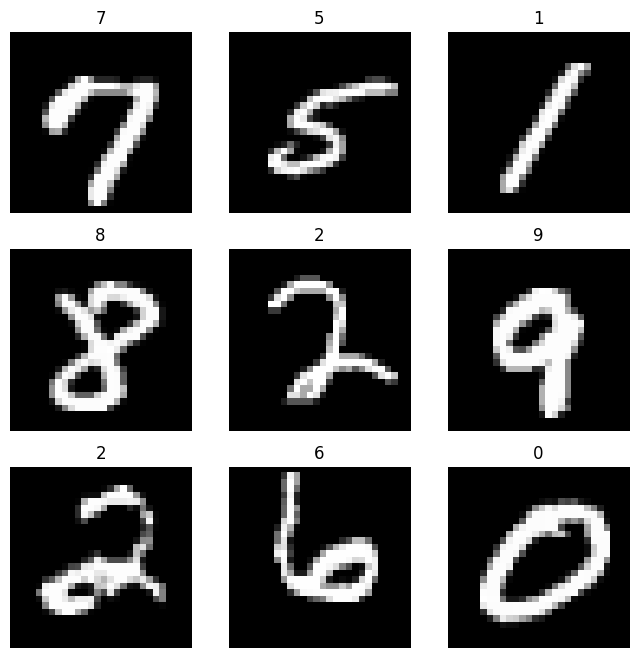

In [9]:
#Graficamos algunas images de ejemplo
figure = plt.figure(figsize=(8,8))
fils, cols = 3, 3

for i in range(1, cols * fils + 1):
    #Generamos un indice aleatorio
    sample_idx = int(torch.randint(len(data_mnist), size=(1,)).item())
    #Obtenemos la imagen y el label
    img, label = data_mnist[sample_idx]
    #Graficamos
    figure.add_subplot(fils, cols, i)
    plt.title(str(label)) #Categoria
    plt.axis("off") #No mostramos los ejes
    plt.imshow(img.squeeze(), cmap="gray") #Imagen (squeeze por que la imagen es de 1x28x28)
plt.show()


In [10]:
#Caracteristicas de una image
print(f'Tipo de dato imagen: {type(img)}')
print(f'Dimensiones de la imagen: {img.shape}')
print(f'Minimo y maximo imagen: {img.min()}, {img.max()}')
print(f'Tipo de categoria: {type(label)}')


Tipo de dato imagen: <class 'torch.Tensor'>
Dimensiones de la imagen: torch.Size([1, 28, 28])
Minimo y maximo imagen: 0.0, 1.0
Tipo de categoria: <class 'int'>


Cada imagen tiene estas características:

Es un Tensor
Tiene un tamaño de 1x28x28 (el 1 indica que es una imagen en escala de grises)
Sus pixeles tienen valores entre 0 y 1
Por otra parte es importante tener en cuenta que la categoría está por defecto almacenada como un entero (int) y no como un tensor. Esto implica que más adelante tendremos que convertir la categoría de cada imagen a un tensor para que pueda ser procesada por la Red Neuronal.

#### 4.2. Sets de entrenamiento, validación y prueba

Siempre que construimos un modelo de Deep Learning debemos realizar la partición del set de datos en entrenamiento, validación y prueba.

En este caso haremos la partición usando proporciones del 80, 10 y 10% respectivamente.

Esto lo podemos lograr fácilmente usando el método random_split de Pytorch.

Para ello, primero fijamos la semilla del generador de números aleatorio de Pytorch, lo que garantizará que cada vez que ejecutemos el código obtendremos las mismas particiones:

In [11]:
torch.manual_seed(42)


In [12]:
train, val, test = torch.utils.data.random_split(
    data_mnist,
    [0.8,0.1,0.1]
)
print(f'Total de imagenes en el set de entrenamiento: {len(train)}, {type(train)}')
print(f'Total de imagenes en el set de validacion: {len(val)}, {type(val)}')
print(f'Total de imagenes en el set de prueba: {len(test)}, {type(test)}')

Total de imagenes en el set de entrenamiento: 48000, <class 'torch.utils.data.dataset.Subset'>
Total de imagenes en el set de validacion: 6000, <class 'torch.utils.data.dataset.Subset'>
Total de imagenes en el set de prueba: 6000, <class 'torch.utils.data.dataset.Subset'>


Y vemos que los tres subsets de datos son de tipo dataset.

Ya estamos listos para ver cómo crear el modelo (la Red Neuronal).

#### 5. ¿Cómo crear un modelo de Deep Learning?

Crearemos una sencilla Red Neuronal con estas características:

Capa de entrada: 28x28 = 784 elementos
Capa oculta: 15 neuronas, activación ReLU
Capa de salida: 10 neuronas (1 por cada categoría a predecir), activación softmax5. ¿Cómo crear un modelo de Deep Learning?
Crearemos una sencilla Red Neuronal con estas características:

Capa de entrada: 28x28 = 784 elementos
Capa oculta: 15 neuronas, activación ReLU
Capa de salida: 10 neuronas (1 por cada categoría a predecir), activación softmax

Adicionalmente, antes de llevar cada imagen a la Red tendremos que aplanarla para convertirla de un tensor 3D de 1x28x28 a un tensor de 1D de 28x28 = 784 (el mismo tamaño de la capa de entrada de la Red)
Para crear la Red Neuronal debemos crear una sub-clase de nn.Module. Veamos cómo hacerlo:

In [13]:
#Importamos modulo nn
from torch import nn 

# Crear la Red Neuronal como una subclase de nn.Module
# Siempre se añaden dos métodos a esta subclase
# 1. Método "init": define la arquitectura de la red
# 2. Método "forward": define cómo será generada cada predicción

# Creamos una sub-clase de nn.Module
class RedNeuronal(nn.Module):
    def __init__(self):
        super().__init__()

        #Agregamos secuencialmente las capas de la red
        self.aplanar = nn.Flatten() #Aplana las imagenes de 1x28x28 a 1D de 784 elementos
        self.red = nn.Sequential(
            nn.Linear(28*28, 15), #Capa de entrada + capa oculta
            nn.ReLU(), #Activacion ReLU
            nn.Linear(15, 10) #Capa de salida
        )
    def forward(self, x):
        x = self.aplanar(x)
        logits = self.red(x)
        return logits

Nota: a pesar de que la capa de salida debería tener una activación softmax esta no se incluye porque no es necesaria para el entrenamiento (sólo es necesaria para garantizar que las salidas de cada neurona de salida suman exactamente 1).

Habiendo creado la clase ya podemos crear la Red Neuronal simplemente:

Creando una instancia de la clase RedNeuronal
Y moviendo esta instancia a la GPU

In [14]:
modelo = RedNeuronal().to(device)
print(modelo)

RedNeuronal(
  (aplanar): Flatten(start_dim=1, end_dim=-1)
  (red): Sequential(
    (0): Linear(in_features=784, out_features=15, bias=True)
    (1): ReLU()
    (2): Linear(in_features=15, out_features=10, bias=True)
  )
)


In [15]:
# Podemos usar el método parameters() para imprimir en pantalla el número de parámetros a entrenar en este modelo:
total_params = sum(p.numel()for p in modelo.parameters())
print(f'Numero de parametros a entrenar: {total_params}')

Numero de parametros a entrenar: 11935


#### 6. Propagación hacia adelante y hacia atrás
La propagación hacia adelante y hacia atrás son las dos fases clave al momento de entrenar la Red Neuronal.

Veamos cada fase en detalle:

6.1. Propagación hacia adelante (forward propagation)
Con la propagación hacia adelante se toma el dato de entrada ( X ), la Red lo procesa y genera una predicción ( ypred  ):

In [16]:
# Extraer una imagen y su categoría del set de entrenamiento
img, lbl = train[200]

print(type(img))
print(type(lbl))
#Vemos que la imagen es un Tensor mientras que la categoría es un entero. Debemos convertir esta categoría a un tensor para poder presentarla al modelo:

<class 'torch.Tensor'>
<class 'int'>


In [17]:
# Convertir "lbl" a Tensor usando "tensor", definir tamaño igual a 1 (1 dato)
# con "reshape"
lbl = torch.tensor(lbl).reshape(1)
print(type(lbl))

<class 'torch.Tensor'>


In [18]:
# Ahora llevamos tanto el dato como su categoría a la GPU:
img, lbl = img.to(device), lbl.to(device)

In [19]:
logits = modelo(img)
print(logits)

tensor([[-0.2088, -0.1774,  0.2579,  0.1910,  0.0531, -0.1378, -0.1164, -0.0240,
         -0.3448,  0.0655]], device='cuda:0', grad_fn=<AddmmBackward0>)


tensor([2], device='cuda:0')
Logits: tensor([[-0.2088, -0.1774,  0.2579,  0.1910,  0.0531, -0.1378, -0.1164, -0.0240,
         -0.3448,  0.0655]], device='cuda:0', grad_fn=<AddmmBackward0>)
Categoría predicha: 2
Categoría real: 0


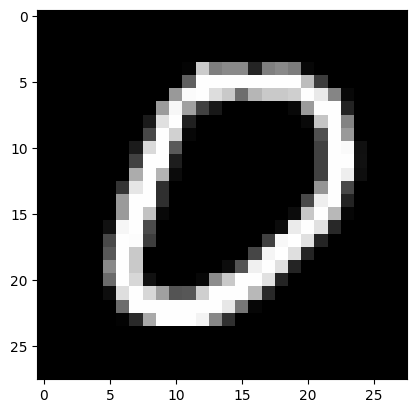

In [20]:
#La predicción (o logits) es un arreglo no normalizado de 10 valores numéricos (puesto que tenemos 10 categorías).

#No normalizado implica que su suma no es igual a 1. Para normalizarlo se puede usar la función softmax aunque no es necesario, podemos calcular la categoría predicha simplemente encontrando la posición donde se encuentre el valor máximo:

y_pred = logits.argmax(dim=1)
print(y_pred)

# Mostremos la imagen 
plt.imshow(img.cpu().squeeze(), cmap='gray')

print(f'Logits: {logits}')
print(f'Categoría predicha: {y_pred[0]}')
print(f'Categoría real: {lbl[0]}')

¡Es de esperar que la categoría predicha (2) o coincida con la categoría real (0) pesto que no hemos entrenado la Red Neuronal!

Veamos ahora la segunda fase que hace parte del entrenamiento: la propagación hacia atrás.

6.2. Propagación hacia atrás (backward propagation o backprop)
Esta propagación hacia atrás permite actualizar los parámetros del modelo con base en el gradiente de la pérdida.

La idea básica es ajustar estos parámetros para minimizar la pérdida (mejorando así las predicciones).

Los pasos involucrados en esta propagación hacia atrás son:

Definir la pérdida (función que se usará para comparar las predicciones con las categorías reales) y el optimizador (algoritmo que se usará para ajustar los parámetros y minimizar la pérdida)
Tomar cada predicción (logits), compararla con la categoría real correspondiente (y) y calcular la pérdida (loss)
Calcular los gradientes de la pérdida (derivadas con respecto a cada parámetro)
Actualizar los parámetros del modelo usando los gradientes y un algoritmo de optimización (como por ejemplo el Gradiente Descendente):

Veamos cómo implementar cada uno de estos pasos.

Comencemos definiendo la función de pérdida (entropía cruzada) y el optimizador a usar (Gradiente Descendente). En este último caso usaremos una tasa de aprendizaje de 0.2:

In [21]:
fn_perdida = nn.CrossEntropyLoss()
optimizador = torch.optim.SGD(modelo.parameters(), lr=0.2)

Vemos que al definir el optimizador el primer argumento son los parámetros del modelo (modelo.parameters()).

Esto permite "conectar" el modelo al optimizador de tal manera que durante el entrenamiento el optimizador pueda ajustar los parámetros para mejorar las predicciones.

Ahora tomamos la predicción (que se obtuvo con la propagación hacia adelante), la comparamos con la categoría real y calculamos la pérdida. La

Esto se hace con una sola línea de código:

In [22]:
loss = fn_perdida(logits, lbl)
print(loss)

tensor(2.4832, device='cuda:0', grad_fn=<NllLossBackward0>)


Ahora calculamos los gradientes de la pérdida. Esto logra usando el método backward() asociado a la variable loss:

In [23]:
loss.backward()

Y finalmente actualizamos los parámetros del modelo usando el optimizador.

Esto se logra en dos pasos:

1. Usando el método `step()` que actualiza los parámetros del modelo
2. Usando el método `zero_grad()` para explícitamente borrar los gradientes calculados anteriormente (pues Pytorch los deja almacenados y esto afecta el entrenamiento).

Estos dos pasos los podemos implementar en dos líneas de código:

In [24]:
optimizador.step()
optimizador.zero_grad()

Y listo, ya tenemos la propagación hacia atrás.

Así que para resumir, re-escribamos todas las líneas de código anteriores para combinar en un sólo bloque la propagación hacia adelante y hacia atrás:

In [25]:
# img: dato, lbl: categoría real

# Propagación hacia adelante (generar predicciones)
logits = modelo(img)

# Propagación hacia atrás
loss = fn_perdida(logits, lbl) # Perdida
loss.backward() # Calcular gradientes
optimizador.step() # Actualizar parámetros del modelo
optimizador.zero_grad() # Borrar gradientes calculados anteriormente

Y listo, tenemos en muy pocas líneas de código los dos pasos esenciales en el entrenamiento de cualquier modelo de Deep Learning: forward + back propagation.

Al entrenar el modelo no usaremos una sola imagen sino que usaremos todo el set de entrenamiento. Y además repetiremos la anterior celda de código varias veces (el número de iteraciones de entrenamiento que definamos).

Así que con todo lo visto hasta este punto ya estamos listos para conectar todos estos elementos y ver cómo se crea, entrena y valida nuestra Red Neuronal para clasificar imágenes.

#### 7. Entrenando y validando un modelo: ejemplo completo
En esta última parte simplemente tomaremos las porciones de código de las secciones anteriores y las organizaremos para entender la lógica de creación, entrenamiento y validación de la Red Neuronal.

Veamos todo esto en detalle.

7.1. Creación de la Red Neuronal
Escribamos en una sola celda el código necesario para crear la clase y la instancia correspondiente a nuestro modelo:

In [26]:
# Clase
class RedNeuronal(nn.Module):
    # 1. Método "init"
    def __init__(self):
        super().__init__()

        # Y agregar secuencialmente las capas
        self.aplanar = nn.Flatten() # Aplanar imágenes de entrada
        self.red = nn.Sequential(
            nn.Linear(28*28, 15), # Capa de entrada + capa oculta
            nn.ReLU(), # Función de activación capa oculta
            nn.Linear(15,10), # Capa de salida SIN activación
        )

    # 2. Método "forward" (x = dato de entrada)
    def forward(self, x):
        # Definir secuencialmente las operaciones a aplicar
        x = self.aplanar(x) # Aplanar dato
        logits = self.red(x) # Generar predicción

        return logits

# Instancia (llevada a la GPU)
modelo = RedNeuronal().to(device)

Antes de entrenar la Red (usando el código para la propagación hacia adelante y hacia atrás), debemos preparar nuestros set de entrenamiento y validación. Veamos cómo hacer esto.
7.2. Preparar los sets de entrenamiento y validación
El set de entrenamiento nos permitirá usar la propagación hacia adelante y hacia atrás para automáticamente actualizar los parámetros del modelo.

Por su parte el set de validación se usará para que tras cada iteración de entrenamiento, pongamos a prueba el modelo y verifiquemos su desempeño.

Como tenemos muchos datos de entrenamiento (48.000) y muchos de validación (6.000) no podemos presentarlos en bloque al modelo pues habría problemas con la memoria RAM.

En lugar de ello los presentamos por lotes (batches), es decir pequeños grupos de datos.

Para poder crear estos lotes y presentarlos al modelo usamos DataLoaderel segundo módulo de procesamiento de datos que posee Pytorch:

In [27]:
from torch.utils.data import DataLoader

TAM_LOTE = 1000 # batch size

# Creamos el DataLoader para el set de entrenamiento y vali

train_loader = DataLoader(
    train,
    batch_size=TAM_LOTE,
    shuffle=True, # Mezclamos los datos 
)
val_loader = DataLoader(
    val,
    batch_size=TAM_LOTE,
    shuffle=False, # No mezclamos los datos
)


Cuando entrenemos y validemos el modelo le presentaremos, en cada iteración, las variables train_loader y val_loader para que se realice el entrenamiento y la validación.

Así que ya tenemos todo listo para realizar este entrenamiento y validación de la red. Veamos el código.

7.3. Entrenamiento y validación del modelo
Comencemos definiendo los hiper-parámetros: la tasa de aprendizaje del algoritmo de optimización y el número de iteraciones de entrenamiento:

In [28]:
TASA_APRENDIZAJE = 0.1 # learning rate
EPOCHS = 10 # epochs

In [29]:
fn_perdida = nn.CrossEntropyLoss()
optimizador = torch.optim.SGD(modelo.parameters(), lr=TASA_APRENDIZAJE)

Ahora crearemos la función train_loop que se ejecutará en cada iteración del entrenamiento.

Esta función usa las dos fases vistas anteriormente: propagación hacia adelante y hacia atrás.

Además, en cada iteración calcularemos dos variables que nos permitirán monitorear el progreso del entrenamiento:

perdida_train: valores promedio de la función de pérdida en cada iteración
exactitud: valores promedio (en cada iteración) de la exactitud del modelo al momento de clasificar los datos. La exactitud es simplemente el porcentaje de datos clasificados correctamente con respecto al total de datos clasificados.
Veamos cómo implementar esta función:

In [30]:
def train_loop(dataloader, model, loss_fn, optimizer):
    # Cantidad de datos de entrenamiento y cantidad de lotes
    train_size = len(dataloader.dataset) #48000
    nlotes = len(dataloader) #48

    #Indicarle a Pytorch que el modelo está en modo entrenamiento
    modelo.train()

    # Inicializar acumuladores de pérdida y exactitud
    perdida_train, exactitud = 0, 0

    for nlote, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Propagación hacia adelante
        logits = model(X)

        # Propagación hacia atrás
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Acumular valores de pérdida y exactitud
        # perdida_train <- perdida_train + perdida_actual
        # exactitud <- exactitud + numero_aciertos_actuales
        perdida_train += loss.item()
        exactitud += (logits.argmax(1) == y).type(torch.float).sum().item()

        # Imprimimos la evolucion del entrenamiento cada 10 lotes
        if nlote % 10 == 0: #Cuando sea un multiplo de 10 imprimimos
            # Optenemos el valor de la perdida actual y el numero de datos procesados
            ndatos = nlote*TAM_LOTE #Cantidad de datos procesados

            print(f"\tPerdida: {loss.item():>7f} [{ndatos:>5d}/{train_size:>5d}]")

    # Calcular valores promedio de pérdida y exactitud
    perdida_train /= nlotes #Promedio de la perdida
    exactitud /= train_size #Promedio de la exactitud

    print(f"Perdida promedio: {perdida_train:>8f} | Exactitud: {100*exactitud:>0.1f}%")

    





In [31]:
def val_loop(dataloader, model, loss_fn):
    #Cantidad de datos de validacion
    val_size = len(dataloader.dataset)
    nlotes = len(dataloader)

    #Indicarle a Pytorch que el modelo está en modo evaluación
    model.eval()

    #Inicializar acumuladores de pérdida y exactitud
    perdida_val, exactitud = 0, 0

    #Desactivar el calculo de gradientes
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            #Propagación hacia adelante
            logits = model(X)

            #Acutalizar acumuladores de pérdida y exactitud
            perdida_val += loss_fn(logits, y).item()
            exactitud += (logits.argmax(1) == y).type(torch.float).sum().item()
    #Tras finalizar el bucle, calcular valores promedio de pérdida y exactitud
    perdida_val /= nlotes
    exactitud /= val_size

    print(f"Perdida promedio: {perdida_val:>8f} | Exactitud: {100*exactitud:>0.1f}%")


¡Y listo! Ya tenemos todo lo necesario para entrenar y validar nuestro modelo de Deep Learning.

Sólo nos restan unas cuantas líneas de código en las cuales de forma iterativa llamaremos las dos funciones que acabamos de crear (train_loop y val_loop):

In [32]:
for t in range(EPOCHS):
    print(f'Iteracion {t+1}\n----------------------------------')
    #Entrenamiento
    train_loop(train_loader, modelo, fn_perdida, optimizador)
    # Validacion
    val_loop(val_loader, modelo, fn_perdida)
print("Entrenamiento finalizado")

Iteracion 1
----------------------------------
	Perdida: 2.310895 [    0/48000]
	Perdida: 2.115603 [10000/48000]
	Perdida: 1.909765 [20000/48000]
	Perdida: 1.661994 [30000/48000]
	Perdida: 1.396372 [40000/48000]
Perdida promedio: 1.791962 | Exactitud: 56.9%
Perdida promedio: 1.187725 | Exactitud: 76.2%
Iteracion 2
----------------------------------
	Perdida: 1.173304 [    0/48000]
	Perdida: 1.041067 [10000/48000]
	Perdida: 0.865448 [20000/48000]
	Perdida: 0.786057 [30000/48000]
	Perdida: 0.695490 [40000/48000]
Perdida promedio: 0.871775 | Exactitud: 80.6%
Perdida promedio: 0.685640 | Exactitud: 83.4%
Iteracion 3
----------------------------------
	Perdida: 0.679566 [    0/48000]
	Perdida: 0.579053 [10000/48000]
	Perdida: 0.581677 [20000/48000]
	Perdida: 0.589693 [30000/48000]
	Perdida: 0.535227 [40000/48000]
Perdida promedio: 0.588127 | Exactitud: 85.2%
Perdida promedio: 0.536181 | Exactitud: 86.3%
Iteracion 4
----------------------------------
	Perdida: 0.497756 [    0/48000]
	Perdida

¡Perfecto! En este punto ya hemos entrenado y validado nuestro modelo.

Podemos ver que en la iteración 10 se tiene una exactitud de casi el 90% con ambos sets (entrenamiento y validación). Así que podemos decir que nuestro modelo esta generando buenas predicciones y que no tiene overfitting.

Sólo nos resta tomar el modelo entrenado y generar predicciones. Veamos cómo hacerlo.

#### 8. Generando predicciones con el modelo entrenado
Habiendo entrenado el modelo ya podemos comenzar a usarlo para generar predicciones.

Estas predicciones implican que debemos introducir una imagen y el modelo debe predecir la categoría a la que pertenece.

Para ello crearemos una sencilla función (predecir) con estas características:

Entradas: el modelo entrenado y una imagen
Salida: mostrará en pantalla la imagen original y la categoría predicha
Veamos cómo crear esta función:

In [37]:
def predecir(modelo, img):
    # Muevo la imagen al mismo dispositivo que el modelo
    img = img.to(device)
    # Generar predicciones
    logits = modelo(img)
    y_pred = logits.argmax(1).item()

    # Mostramos las imágenes y la predicción
    plt.imshow(img.cpu().squeeze(0), cmap='gray')
    plt.title(f'Prediccion: {y_pred}')

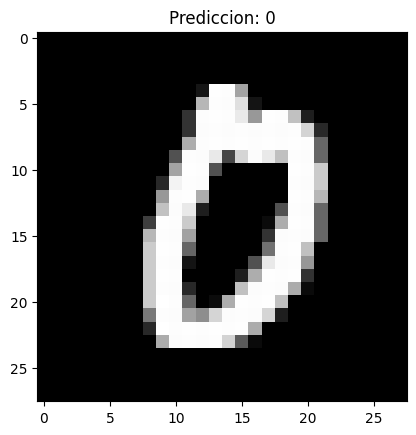

In [42]:
img, lbl = test[1]
predecir(modelo, img)